# Registration Lab
## Load the NIFTI images

In [29]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import histogram

In [19]:
ct_file = nib.load("ct.nii")
mr_file1 = nib.load("mr1.nii")
mr_file2 = nib.load("mr2.nii")

In [20]:
print(ct_file.shape)
print(mr_file1.shape)
print(mr_file2.shape)

(271, 271, 221)
(164, 241, 241)
(165, 240, 241)


In [16]:
print(ct_file.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'?TR:0.000 TE:0.00'
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 271 271 221   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 0.000000e+00
 1.000000e+00 1.000000e+00 3.879853e+04]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 4095
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 

In [21]:
ct_img = ct_file.get_fdata()
mr_img1 = mr_file1.get_fdata()
mr_img2 = mr_file2.get_fdata()
print(ct_img.shape)

(271, 271, 221)


(<AxesSubplot:>,
 (-0.5, 239.5, 164.5, -0.5))

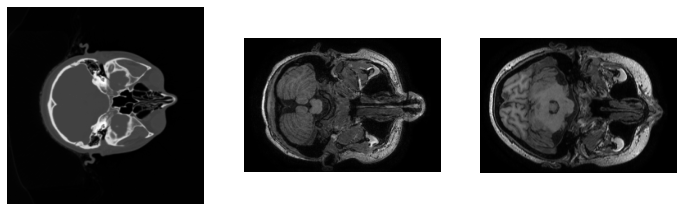

In [24]:
plt.figure(figsize=(12, 8))
plt.subplot(1,3,1), plt.imshow(ct_img[:, :, 100], cmap='gray'), plt.axis('off')
plt.subplot(1,3,2), plt.imshow(mr_img1[:, :, 100], cmap='gray'), plt.axis('off')
plt.subplot(1,3,3), plt.imshow(mr_img2[:, :, 100], cmap='gray'), plt.axis('off')

## Functions
### Interpolation

In [ ]:
def trilinear_interpolation(image, coordinates):
    x, y, z = coordinates[:, 0], coordinates[:, 1], coordinates[:, 2]
    x_int, y_int, z_int = np.floor(x).astype(int), np.floor(y).astype(int), np.floor(z).astype(int)
    x_frac, y_frac, z_frac = x - x_int, y - y_int, z - z_int

    x_int = np.clip(x_int, 0, image.shape[2] - 2)
    y_int = np.clip(y_int, 0, image.shape[1] - 2)
    z_int = np.clip(z_int, 0, image.shape[0] - 2)

    c000 = image[z_int, y_int, x_int]
    c001 = image[z_int, y_int, x_int + 1]
    c010 = image[z_int, y_int + 1, x_int]
    c011 = image[z_int, y_int + 1, x_int + 1]
    c100 = image[z_int + 1, y_int, x_int]
    c101 = image[z_int + 1, y_int, x_int + 1]
    c110 = image[z_int + 1, y_int + 1, x_int]
    c111 = image[z_int + 1, y_int + 1, x_int + 1]

    interpolated_values = (
        c000 * (1 - x_frac) * (1 - y_frac) * (1 - z_frac) +
        c001 * x_frac * (1 - y_frac) * (1 - z_frac) +
        c010 * (1 - x_frac) * y_frac * (1 - z_frac) +
        c011 * x_frac * y_frac * (1 - z_frac) +
        c100 * (1 - x_frac) * (1 - y_frac) * z_frac +
        c101 * x_frac * (1 - y_frac) * z_frac +
        c110 * (1 - x_frac) * y_frac * z_frac +
        c111 * x_frac * y_frac * z_frac
    )

    return interpolated_values

### Transform

In [ ]:
def rotate_tranform(img, rot_angles=(5, 5)): 
    """Rotates an image for registration algorithms.
    Parameters:
    - img: 2D array 
        img to be rotated
    - rot_angles: tuple of shape (theta, psi)
        angles (in degrees) along which x and y axis are going to be rotated 
    Returns: rot_img, Rotated img (2D array)
    """
    rot_img = np.zeros(img.shape)
    
    x_rot = [[1, 0, 0], 
            [0, np.cos(rot_angles[0]), -np.sin(rot_angles[0])],
            [0, np.sin(rot_angles[0]), np.cos(rot_angles[0])]]
    y_rot = [[np.cos(rot_angles[1]), 0, np.sin(rot_angles[1])], 
            [0, 1, 0], 
            [-np.sin(rot_angles[1]), 0, np.cos(rot_angles[1])]]
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            support = [[i], [j], [1]]
            new_support = support * x_rot * y_rot 
            # SET NEW VALUE WITH INTERPOLATION 
            i_new = new_support[0, 0]
            j_new = new_support[0, 1]
            rot_img[i_new, j_new] = img[i, j]
            
    return rot_img 

In [ ]:
def translate_tranform(img, translate_dist=(5, 5)): 
    """Translates an image for registration algorithms.
    Parameters:
    - img: 2D array 
        img to be translated
    - rot_angles: tuple of shape (alpha, beta)
        angles (in pixels) along which x and y are going to be translated 
    Returns: trans_img, Translated img (2D array)
    """
    trans_img = np.zeros(img.shape)
    
    trans_op = [[1, 0, alpha], 
            [0, 1, beta], 
            [0, 0, 1]]
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            support = [[i], [j], [1]]
            new_support = support * trans_op
            # SET NEW VALUE WITH INTERPOLATION 
            i_new = new_support[0, 0]
            j_new = new_support[0, 1]
            trans_img[i_new, j_new] = img[i, j]
            
    return trans_img 

## Metrics

In [35]:
def calculate_mutual_information(img1, img2): 
    """Calculates the mutual entropy of the two images"""
    
    img1 = img1.flatten()
    img2 = img2.flatten()
    bins = 256
    
    hist_2d, _, _ = np.histogram2d(img1, img2, bins=bins)

    # Calculate marginal histograms
    hist_1d_image1, _ = np.histogram(img1, bins=bins)
    hist_1d_image2, _ = np.histogram(img2, bins=bins)

    # Convert histograms to probabilities
    pxy = hist_2d / float(np.sum(hist_2d))
    px = hist_1d_image1 / float(np.sum(hist_1d_image1))
    py = hist_1d_image2 / float(np.sum(hist_1d_image2))

    # Compute mutual information
    mi = np.sum(pxy * np.log2(pxy / (np.outer(px, py) + 1e-10)))

    return mi



In [36]:
mutual_information = calculate_mutual_information(mr_img1[:, :, 100],mr_img1[:, :, 100])
print(f"Mutual Information: {mutual_information}")

Mutual Information: nan


/tmp/ipykernel_91362/3477909085.py:20: RuntimeWarning: divide by zero encountered in log2
  mi = np.sum(pxy * np.log2(pxy / (np.outer(px, py) + 1e-10)))
/tmp/ipykernel_91362/3477909085.py:20: RuntimeWarning: invalid value encountered in multiply
  mi = np.sum(pxy * np.log2(pxy / (np.outer(px, py) + 1e-10)))
